In [1]:
# Dependencies and Setup
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Dependencies and Setup
import numpy as np
import pandas as pd

In [3]:
# Dependencies and Setup
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
# Create engine 
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspecting the tables
inspector = inspect(engine)
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c["name"], c["type"])
    
print("------------------------------------------")    

s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------------------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

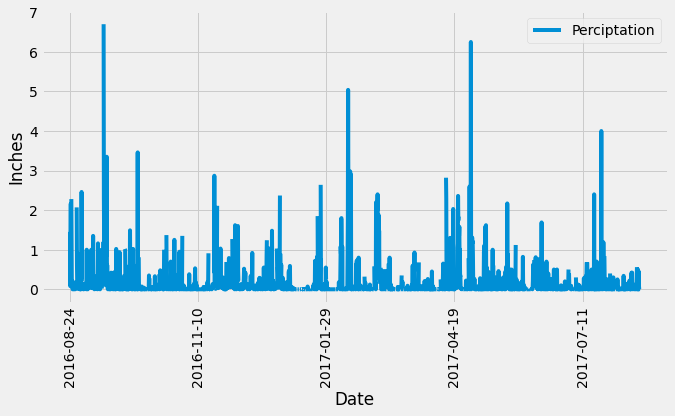

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(func.strftime('%Y-%m-%d', func.max(measurement.date))).first()[0]

# convert the latest date string to datetime
latest_date = dt.datetime(int(latest_date[0:4]), int(latest_date[5:7]), int(latest_date[8:10]))
date_a_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date <= latest_date)\
    .filter(measurement.date >= date_a_year_ago)\
    .order_by(desc(measurement.date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(np.array(prcp_scores), columns=["Date", "Perciptation"])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(['Date'], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x="Date", y="Perciptation", figsize=(10, 5))
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.savefig("Perciptation_by_Date.png", bbox_inches = "tight")


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
a = prcp_df["Perciptation"].describe()
a

count     2015.0
unique     160.0
top          0.0
freq       873.0
Name: Perciptation, dtype: float64

In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(measurement.station.distinct())).first()[0]
print(f"Number of stations: {station_count}")

Number of stations: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_most_records = session\
    .query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(desc(func.count(measurement.station))).all()

for i in stations_most_records:
    print(f"Station: {i[0]}, Number of Records: {i[1]}")
print("")
print(f"Station with the highest number of observations is {stations_most_records[0][0]}")

Station: USC00519281, Number of Records: 2772
Station: USC00519397, Number of Records: 2724
Station: USC00513117, Number of Records: 2709
Station: USC00519523, Number of Records: 2669
Station: USC00516128, Number of Records: 2612
Station: USC00514830, Number of Records: 2202
Station: USC00511918, Number of Records: 1979
Station: USC00517948, Number of Records: 1372
Station: USC00518838, Number of Records: 511

Station with the highest number of observations is USC00519281


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(measurement.tobs))\
    .filter(measurement.station == stations_most_records[0][0]).first()[0]
highest_temp = session.query(func.max(measurement.tobs))\
    .filter(measurement.station == stations_most_records[0][0]).first()[0]
average_temp = session.query(func.avg(measurement.tobs))\
    .filter(measurement.station == stations_most_records[0][0]).first()[0]

print(f"Higest Templrature: {highest_temp}")
print(f"Lowest Templrature: {lowest_temp}")
print(f"Average Templrature: {round(average_temp, 3)}")

Higest Templrature: 85.0
Lowest Templrature: 54.0
Average Templrature: 71.664


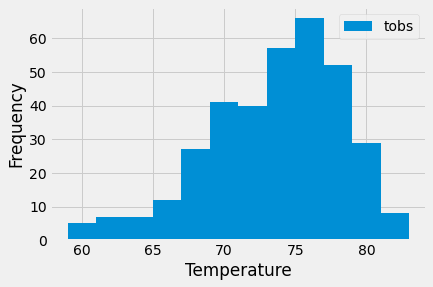

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_highest = session.query(measurement.tobs)\
    .filter(measurement.date > date_a_year_ago)\
    .filter(measurement.date < latest_date)\
    .filter(measurement.station == stations_most_records[0][0])\
    .all()

tobs_df = pd.DataFrame(np.array(tobs_highest), columns=["tobs"])

tobs_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.savefig("Tempurature Frequency.png", bbox_inches = "tight")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
